# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.0


## Download data and generate sequences

Download quijote from guttenberg project

wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2117498
Chars list:  ['\n', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü', '\ufeff']
total chars: 72


In [18]:
text[100000:103000]

', con los hechos del\nemperador, compuestos por don luis de ávila, que, sin duda, debían de estar\nentre los que quedaban; y quizá, si el cura los viera, no pasaran por tan\nrigurosa sentencia.\n\ncuando llegaron a don quijote, ya él estaba levantado de la cama, y\nproseguía en sus voces y en sus desatinos, dando cuchilladas y reveses a\ntodas partes, estando tan despierto como si nunca hubiera dormido.\nabrazáronse con él, y por fuerza le volvieron al lecho; y, después que hubo\nsosegado un poco, volviéndose a hablar con el cura, le dijo:\n\n-por cierto, señor arzobispo turpín, que es gran mengua de los que nos\nllamamos doce pares dejar, tan sin más ni más, llevar la vitoria deste\ntorneo a los caballeros cortesanos, habiendo nosotros los aventureros\nganado el prez en los tres días antecedentes.\n\n-calle vuestra merced, señor compadre -dijo el cura-, que dios será servido\nque la suerte se mude, y que lo que hoy se pierde se gane mañana; y atienda\nvuestra merced a su salud por ag

In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(300, len(text) - maxlen, step): #Start in line 30 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 705726
tregará a medea; si  - d


## Train the model

In [4]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (705726, 20, 72)
y shape:  (705726, 72)


In [5]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras import optimizers

print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(seq_prev_input)

forwards2 = LSTM(512, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(forwards1)

output = Dense(len(chars), activation='softmax')(forwards2)

model = Model(inputs=seq_prev_input, outputs=output)
model.summary()

# try using different optimizers and different optimizer configs
Nadam = optimizers.Nadam(lr=0.0005, schedule_decay=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 20, 72)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 512)           1198080   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 72)                36936     
Total params: 3,334,216.0
Trainable params: 3,334,216.0
Non-trainable params: 0.0
_________________________________________________________________


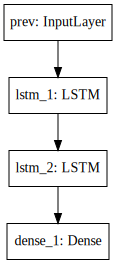

In [6]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
#Fit model
history = model.fit(X[:600000], y[:600000], batch_size=256, epochs=50,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 105726 samples
Epoch 1/50
600000/600000 [==============================] - 204s - loss: 2.3121 - acc: 0.3097 - val_loss: 2.0576 - val_acc: 0.3802
Epoch 2/50
600000/600000 [==============================] - 205s - loss: 1.9436 - acc: 0.4006 - val_loss: 1.8804 - val_acc: 0.4385
Epoch 3/50
600000/600000 [==============================] - 204s - loss: 1.7805 - acc: 0.4495 - val_loss: 1.7690 - val_acc: 0.4736
Epoch 4/50
600000/600000 [==============================] - 205s - loss: 1.6715 - acc: 0.4802 - val_loss: 1.6986 - val_acc: 0.4976
Epoch 5/50
600000/600000 [==============================] - 205s - loss: 1.5947 - acc: 0.5027 - val_loss: 1.6493 - val_acc: 0.5143
Epoch 6/50
600000/600000 [==============================] - 200s - loss: 1.5389 - acc: 0.5187 - val_loss: 1.6182 - val_acc: 0.5250
Epoch 7/50
600000/600000 [==============================] - 201s - loss: 1.4978 - acc: 0.5299 - val_loss: 1.5967 - val_acc: 0.5339
Epoch 8/50
600000/600000 [=====

Train on 600000 samples, validate on 105726 samples
Epoch 1/50
600000/600000 [==============================] - 96s - loss: 2.4896 - acc: 0.2734 - val_loss: 2.1208 - val_acc: 0.3573
Epoch 2/50
600000/600000 [==============================] - 98s - loss: 2.0241 - acc: 0.3775 - val_loss: 1.9248 - val_acc: 0.4214
Epoch 3/50
600000/600000 [==============================] - 96s - loss: 1.8431 - acc: 0.4304 - val_loss: 1.7974 - val_acc: 0.4645
Epoch 4/50
600000/600000 [==============================] - 96s - loss: 1.7160 - acc: 0.4674 - val_loss: 1.7106 - val_acc: 0.4908
Epoch 5/50
600000/600000 [==============================] - 96s - loss: 1.9464 - acc: 0.4114 - val_loss: 2.3071 - val_acc: 0.3025
Epoch 6/50
600000/600000 [==============================] - 96s - loss: 2.1581 - acc: 0.3424 - val_loss: 2.0364 - val_acc: 0.3888
Epoch 7/50
600000/600000 [==============================] - 96s - loss: 1.9694 - acc: 0.3941 - val_loss: 1.9155 - val_acc: 0.4266
Epoch 8/50
600000/600000 [==============================] - 96s - loss: 1.8541 - acc: 0.4282 - val_loss: 1.8315 - val_acc: 0.4557
Epoch 9/50
600000/600000 [==============================] - 96s - loss: 1.7714 - acc: 0.4514 - val_loss: 1.7699 - val_acc: 0.4758
Epoch 10/50
600000/600000 [==============================] - 96s - loss: 1.7077 - acc: 0.4693 - val_loss: 1.7328 - val_acc: 0.4897
Epoch 11/50
600000/600000 [==============================] - 96s - loss: 1.6551 - acc: 0.4846 - val_loss: 1.6905 - val_acc: 0.5043
Epoch 12/50
600000/600000 [==============================] - 96s - loss: 1.6137 - acc: 0.4961 - val_loss: 1.6674 - val_acc: 0.5102
Epoch 13/50
600000/600000 [==============================] - 96s - loss: 1.5794 - acc: 0.5058 - val_loss: 1.6454 - val_acc: 0.5168
Epoch 14/50
600000/600000 [==============================] - 96s - loss: 1.5499 - acc: 0.5141 - val_loss: 1.6272 - val_acc: 0.5257
Epoch 15/50
600000/600000 [==============================] - 96s - loss: 1.5224 - acc: 0.5214 - val_loss: 1.6116 - val_acc: 0.5277
Epoch 16/50
600000/600000 [==============================] - 96s - loss: 1.5012 - acc: 0.5281 - val_loss: 1.5944 - val_acc: 0.5330
Epoch 17/50
600000/600000 [==============================] - 96s - loss: 1.4810 - acc: 0.5333 - val_loss: 1.5863 - val_acc: 0.5339
Epoch 18/50
600000/600000 [==============================] - 96s - loss: 1.4620 - acc: 0.5388 - val_loss: 1.5734 - val_acc: 0.5398
Epoch 19/50
600000/600000 [==============================] - 96s - loss: 1.4468 - acc: 0.5433 - val_loss: 1.5649 - val_acc: 0.5425
Epoch 20/50
600000/600000 [==============================] - 96s - loss: 1.4318 - acc: 0.5477 - val_loss: 1.5570 - val_acc: 0.5453
Epoch 21/50
600000/600000 [==============================] - 96s - loss: 1.4196 - acc: 0.5508 - val_loss: 1.5493 - val_acc: 0.5475
Epoch 22/50
600000/600000 [==============================] - 96s - loss: 1.4055 - acc: 0.5544 - val_loss: 1.5436 - val_acc: 0.5515
Epoch 23/50
600000/600000 [==============================] - 96s - loss: 1.3941 - acc: 0.5574 - val_loss: 1.5424 - val_acc: 0.5515
Epoch 24/50
600000/600000 [==============================] - 96s - loss: 1.3840 - acc: 0.5599 - val_loss: 1.5342 - val_acc: 0.5523
Epoch 25/50
600000/600000 [==============================] - 96s - loss: 1.3754 - acc: 0.5633 - val_loss: 1.5301 - val_acc: 0.5546
Epoch 26/50
600000/600000 [==============================] - 96s - loss: 1.3643 - acc: 0.5664 - val_loss: 1.5272 - val_acc: 0.5566
Epoch 27/50
600000/600000 [==============================] - 96s - loss: 1.3556 - acc: 0.5680 - val_loss: 1.5248 - val_acc: 0.5587
Epoch 28/50
600000/600000 [==============================] - 96s - loss: 1.3482 - acc: 0.5701 - val_loss: 1.5176 - val_acc: 0.5590
Epoch 29/50
600000/600000 [==============================] - 96s - loss: 1.3419 - acc: 0.5719 - val_loss: 1.5156 - val_acc: 0.5609
Epoch 30/50
600000/600000 [==============================] - 96s - loss: 1.3337 - acc: 0.5739 - val_loss: 1.5126 - val_acc: 0.5608
Epoch 31/50
600000/600000 [==============================] - 96s - loss: 1.3271 - acc: 0.5760 - val_loss: 1.5107 - val_acc: 0.5623
Epoch 32/50
600000/600000 [==============================] - 96s - loss: 1.3202 - acc: 0.5780 - val_loss: 1.5065 - val_acc: 0.5637
Epoch 33/50
600000/600000 [==============================] - 96s - loss: 1.3145 - acc: 0.5792 - val_loss: 1.5059 - val_acc: 0.5648
Epoch 34/50
600000/600000 [==============================] - 96s - loss: 1.3090 - acc: 0.5810 - val_loss: 1.5047 - val_acc: 0.5638
Epoch 35/50
600000/600000 [==============================] - 96s - loss: 1.3031 - acc: 0.5827 - val_loss: 1.5042 - val_acc: 0.5650
Epoch 36/50
600000/600000 [==============================] - 96s - loss: 1.2987 - acc: 0.5836 - val_loss: 1.4984 - val_acc: 0.5671
Epoch 37/50
600000/600000 [==============================] - 96s - loss: 1.2936 - acc: 0.5852 - val_loss: 1.4981 - val_acc: 0.5670
Epoch 38/50
600000/600000 [==============================] - 96s - loss: 1.2870 - acc: 0.5875 - val_loss: 1.4989 - val_acc: 0.5678
Epoch 39/50
600000/600000 [==============================] - 96s - loss: 1.2828 - acc: 0.5884 - val_loss: 1.4959 - val_acc: 0.5692
Epoch 40/50
600000/600000 [==============================] - 96s - loss: 1.2787 - acc: 0.5897 - val_loss: 1.4948 - val_acc: 0.5676
Epoch 41/50
600000/600000 [==============================] - 96s - loss: 1.2746 - acc: 0.5908 - val_loss: 1.4946 - val_acc: 0.5692
Epoch 42/50
600000/600000 [==============================] - 96s - loss: 1.2689 - acc: 0.5921 - val_loss: 1.4941 - val_acc: 0.5701
Epoch 43/50
600000/600000 [==============================] - 96s - loss: 1.2656 - acc: 0.5924 - val_loss: 1.4905 - val_acc: 0.5711
Epoch 44/50
600000/600000 [==============================] - 96s - loss: 1.2619 - acc: 0.5934 - val_loss: 1.4903 - val_acc: 0.5708
Epoch 45/50
600000/600000 [==============================] - 96s - loss: 1.2585 - acc: 0.5947 - val_loss: 1.4896 - val_acc: 0.5718
Epoch 46/50
600000/600000 [==============================] - 96s - loss: 1.2544 - acc: 0.5948 - val_loss: 1.4890 - val_acc: 0.5722
Epoch 47/50
600000/600000 [==============================] - 95s - loss: 1.2501 - acc: 0.5966 - val_loss: 1.4903 - val_acc: 0.5728
Epoch 48/50
600000/600000 [==============================] - 95s - loss: 1.2469 - acc: 0.5975 - val_loss: 1.4901 - val_acc: 0.5733
Epoch 49/50
600000/600000 [==============================] - 95s - loss: 1.2443 - acc: 0.5980 - val_loss: 1.4905 - val_acc: 0.5739
Epoch 50/50
600000/600000 [==============================] - 95s - loss: 1.2396 - acc: 0.5997 - val_loss: 1.4882 - val_acc: 0.5729

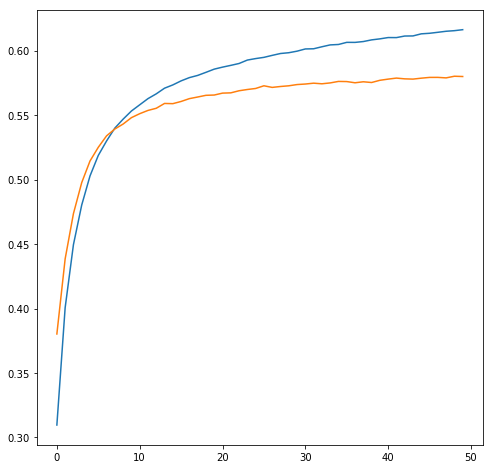

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [9]:
from keras.models import save_model

save_model(model, path + 'models/text_generation_model.h5')


## Evaluate model

In [10]:
from keras.models import load_model

model1 = load_model(path + 'models/text_generation_model.h5')


In [11]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [21]:
sentence = ' mi señora dulcinea '
generate_text(sentence, 0.5, model1)

/home/jorge/anaconda3/envs/keras2_py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.5
 mi señora dulcinea del toboso
   de donde pasó más de las manos en la mitad del camino que se le había de parar todas aquellas que de la profunda se lo dicen, no pudo ningún fin de los caballeros andantes, que el barbero se consigo, y aun las representan cada uno de los que pudiera ser estado, pues si la sobrina


-pues está en mi profesión y más alto y el mesmo que hacer en el cuerpo de la mancha, y el cual se le c


In [22]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = ' mi señora dulcinea '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'el caballero andant3'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


/home/jorge/anaconda3/envs/keras2_py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.2
mire vuestra merced se le ofreció de la mancha, y que no se ha de ser tan buena gana de la mancha, y que el amor de la mancha, y que no se puede ser tan sabio que le pareció a decir que es mucha presencia del toboso, que es tan deseo de ser que el cura y el amo no le hallaba en la cabeza, y de la mancha, y que no se puede ser alguna peligrosa aventura, y el cura y el caballero del señor don quijote, y de la mancha, y

DIVERSITY:  0.5
mire vuestra merced que se considera que le había de estar otra cosa.

-no se ha de dejar de esperar a una carta de su caballería, y
que le dijo que se estaba despertar puesto el camino que tanto se quiero decir que la suerte, y no se ha de parar aquel pasado en la cabeza, en la tierra y del cielo
que el cura y el barbero andante caballero andante.

-eso no quiero decir que quisiera que deseaba de ser cosa de don fer

DIVERSITY:  1
mire vuestra merced basta que no temiese por el gigante de caballerías quisiera hacer lo que encaminaba vara 